In [1]:
import numpy as np
import pywt
import cv2
from pathlib import Path
import scipy.io as sio

from spyrit.misc.disp import *
from spyrit.learning.model_Had_DCAN import *


In [2]:
def simulated_noisy_images(gt_list, max_list, K, H):
    gt_index = max_list.index(max(max_list));
    GT = gt_list[gt_index];
    N = GT.shape[0];
    H_pos = np.zeros(H.shape);
    H_neg = np.zeros(H.shape);
    H_pos[H>0] = N*H[H>0];
    H_neg[H<0] = -N*H[H<0];
    simu_list = [];
    for i in range(len(gt_list)):
        if i!=gt_index:
            f_noi = simulated_measurement(GT, max_list[i]/K, H_pos, H_neg, N, H)
        else:
            f_noi = GT;
        simu_list.append(f_noi)
    return simu_list


def simulated_measurement(GT, N0, H_pos, H_neg, N, H):
    f = N0*np.reshape(((GT-np.amin(GT))/(np.amax(GT)-np.amin(GT))), (N**2,1));
    m_pos = np.dot(H_pos,f);
    m_neg = np.dot(H_neg,f);
    m_pos += np.multiply(np.sqrt(m_pos),np.random.normal(0,1,size = m_pos.shape));
    m_neg += np.multiply(np.sqrt(m_neg),np.random.normal(0,1,size = m_neg.shape));
    m_noi = m_pos-m_neg;
    f_noi = np.reshape((1/N)*np.dot(H, m_pos-m_neg), (N, N));
    f_noi = 2*(f_noi-np.amin(f_noi))/(np.amax(f_noi)-np.amin(f_noi))-1;
    return f_noi;



def simu_raw_meas(GT, N0, N, H, mu, sigma, K):
    f = N0*np.reshape(((GT-np.amin(GT))/(np.amax(GT)-np.amin(GT))), (N**2,1));
    m = np.dot(H,f);
    m = K*np.random.poisson(m)+np.random.normal(mu,sigma,size = m.shape);
    return m;

In [3]:
img_size = 64
CR = 512
img = pywt.data.camera()
img = cv2.resize(img, (img_size,img_size), interpolation = cv2.INTER_AREA)
img = (img-np.amin(img))/(np.amax(img)-np.amin(img))

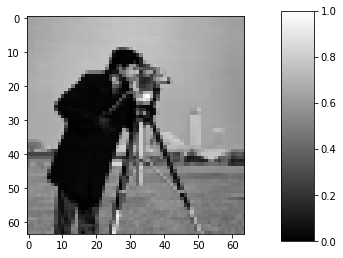

In [4]:
imagesc(img)

In [5]:
expe_root = "../../data/expe_2/" # Path to precomputed data
precompute_root ="../../models/SDCAN/"# Path to precomputed data
precompute=False
my_average_file = Path(precompute_root) / ('Average_{}x{}'.format(img_size, img_size)+'.npy')
my_cov_file = Path(precompute_root) / ('Cov_{}x{}'.format(img_size, img_size)+'.npy')

Path(precompute_root).mkdir(parents=True, exist_ok=True)
if not(my_average_file.is_file()) or not(my_cov_file.is_file()) or precompute:
    print('Computing covariance and mean (overwrite previous files)')
    Mean_had, Cov_had = Stat_had(trainloader, precompute_root)
else:
    print('Loading covariance and mean')
    Mean_had = np.load(my_average_file)
    Cov_had  = np.load(my_cov_file)

if expe_root:
    my_transform_file = Path(expe_root) / ('transform_{}x{}'.format(img_size, img_size)+'.mat')
    H = sio.loadmat(my_transform_file);
    H = (1/img_size)*H["H"]

    my_average_file = Path(expe_root) / ('Average_{}x{}'.format(img_size, img_size)+'.mat')
    my_cov_file = Path(expe_root) / ('Cov_{}x{}'.format(img_size, img_size)+'.mat')
    Mean_had_1 = sio.loadmat(my_average_file)
    Cov_had_1  = sio.loadmat(my_cov_file)

    Mean_had_1 = Mean_had_1["mu"]-np.dot(H, np.ones((img_size**2,1)));
    Mean_had_1 = np.reshape(Mean_had_1,(img_size, img_size));
    Mean_had_1 = np.amax(Mean_had)/np.amax(Mean_had_1)*Mean_had_1;
    Cov_had_1 = Cov_had_1["C"];
    Cov_had_1 = np.amax(Cov_had)/np.amax(Cov_had_1)*Cov_had_1;
    Cov_had = Cov_had_1;
    Mean_had = Mean_had_1;

else :
    H = None;
    
Var = Cov2Var(Cov_had_1)
Perm = Permutation_Matrix(Var)


Loading covariance and mean


In [6]:
Pmat = np.dot(Perm,H);
Pmat = img_size*Pmat[:CR,:];

In [7]:
Pmat.shape

(512, 4096)

In [8]:
H_pos = np.zeros((CR, img_size**2));
H_neg = np.zeros((CR, img_size**2));
H_pos[Pmat>0] = Pmat[Pmat>0];
H_neg[Pmat<0] = -Pmat[Pmat<0];

In [9]:
N0=10;
K =1.6;
C = 1070;
s = 55;


In [10]:
m_pos = simu_raw_meas(img, N0, img_size, H_pos, C, s, K);
m_neg = simu_raw_meas(img, N0, img_size, H_neg, C, s, K);

In [11]:
y = m_pos+m_neg-2*C

In [12]:
(2*np.mean(y))/(K*img_size**2)

9.549660068794278

In [17]:
2*(np.std(y)**2-2*s**2)/(K*img_size**2)

16.63247186063322